# Multivariate Timeseries Forecasting with the `sert` Python Package

**Author:** Amin Shoari Nejad &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date created:** 2023/09/04

In this notebook, we demonstrate how to utilize the sert package for multivariate timeseries forecasting. The process includes data loading, preprocessing, model instantiation, training, and evaluation.

# 1. Imports

Assuming that you have installed the sert package, we can import the necessary modules.

In [11]:
from sert.models import TimeSERT
from sert.preprocessing import SeqDataPreparer
from sert.datasets import ts_forecasting
from sert.losses import MaskedMSE

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

- **TimeSERT**: This is one of the primary classes of the `sert` package, suitable for both time series classification and multivariate forecasting. In this notebook, we'll use it for multivariate time series forecasting.

- **SeqDataPreparer**: This class assists in preparing data for time series classification. Models within the `sert` package expect data in a particular format, and `SeqDataPreparer` facilitates this transformation. It employs the same `fit_transform` and `transform` syntax found in scikit-learn.

- **ts_forecasting**: This function creates a dataframe including multivariate time series data. Specifically, there are three correlated time series generated from a Gaussian process and they have seasonality and trend. For more details, invoke `help(ts_forecasting)`.

- **MaskedMSE**: This is a custom loss function for training models on sparse data. It is a masked version of the mean squared error (MSE) loss function that masks out the missing values in the output.

# 2. Load the Dataset

Our sert package conveniently provides a multivariate time series dataset for demonstration purposes. To make the learning task more challenging we introduce some gaps in the data. 

In [6]:
# generate the dataset
df = ts_forecasting(time_length=18500)

# randomly sample 20 intervals of length 500
np.random.seed(123)
starts = np.random.randint(100, 15000, 20)
ends = starts + 500
intervals = list(zip(starts, ends))

# introduce the gaps in the dataset
for start, end in intervals:
    # randomly choose a time series column
    col_number = np.random.randint(1, 4, 1)
    # set the values in the interval to NaN
    df.iloc[start:end, col_number] = np.nan

# 3. Data Preprocessing

In order to feed our data into the **TimeSERT** model, we need to perform some preprocessing steps.
First we need to scale the data. We use the `StandardScaler` from scikit-learn for this purpose. To do so we need to fit the scaler on the training data and then transform both the training and test data.

In [7]:
split_time = 15000

train = df.query(f'time <= {split_time}')
test = df.query(f'time > {split_time}')

# --- Scale the data --- #
value_columns = train.drop('time', axis=1).columns

scaler = StandardScaler()

train[value_columns] = scaler.fit_transform(train[value_columns])
test[value_columns] = scaler.transform(test[value_columns])

Remember that our task is to forecast future values of the time series based on past values. A typical approach to preparing training data for time series is to use a sliding window of observations. In this method, each training sample comprises a sequence of observations within an observation window, and the subsequent observations in a prediction window serve as the target values.

Models in sert are designed to work with data in set format (i.e., each row is a single observation with time, variable name, value). We melt the data into this format first and then apply the sliding window method.

In [8]:
train_long = pd.melt(train, id_vars=['time'], value_vars=value_columns)
test_long = pd.melt(test, id_vars=['time'], value_vars=value_columns)
train_long

,time,variable,value
0,1.0,x1,-0.229289
1,2.0,x1,-0.104582
2,3.0,x1,-0.065015
3,4.0,x1,0.083156
4,5.0,x1,0.070011
...,...,...,...
44995,14996.0,x3,1.072004
44996,14997.0,x3,0.891699
44997,14998.0,x3,0.943091
44998,14999.0,x3,1.362988


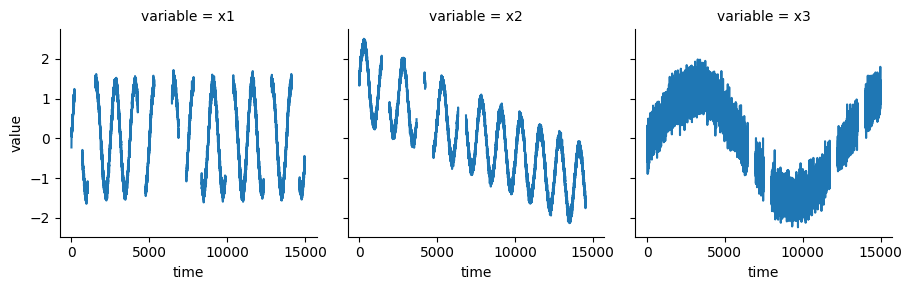

In [9]:
# Plotting the training data
g = sns.FacetGrid(train_long, col="variable", col_wrap=4, height=3)
g = g.map(plt.plot, "time", "value")
plt.show()

In [10]:
def create_dataset(values, times, obs_window_len, forecast_horizon, col_names=None):
    """
    Creates a dataset for multivariate forecasting using a sliding window approach.
    """

    end = np.max(times)
    t = np.min(times)
    X = []
    y = []

    while t <= end - (obs_window_len+forecast_horizon) + 1:

        # extracting observation window
        obs_data = values[(times >= t) & (times < t+obs_window_len)]
        # adding window identifier
        obs_data = np.hstack(
            (obs_data, np.repeat(t, len(obs_data)).reshape(-1, 1)))
        X.append(obs_data)

        pred_hour = t+obs_window_len-1+forecast_horizon  # forecasting hour
        preds = values[times == pred_hour]
        preds = np.hstack((preds, np.repeat(t, len(preds)).reshape(-1, 1)))
        y.append(preds)

        t += 1

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)

    # Extending column names
    col_names_ext = col_names.to_list()
    col_names_ext.append('window')

    X = pd.DataFrame(X, columns=col_names_ext)
    y = pd.DataFrame(y, columns=col_names_ext)
    y = y.pivot(index='window', columns='variable',
                values='value').astype(float)  # .values

    return X, y


# setting the window length and forecast horizon
window_len = 20
horizon = 7

X_train, y_train = create_dataset(train_long.values,
                                  train_long['time'].values,
                                  obs_window_len=window_len,
                                  forecast_horizon=horizon,
                                  col_names=train_long.columns)

X_test, y_test = create_dataset(test_long.values,
                                test_long['time'].values,
                                obs_window_len=window_len,
                                forecast_horizon=horizon,
                                col_names=test_long.columns)

We just applied the sliding window approach to create training sets with a length of 20 observations to forecast the next 7 hours. Due to the gaps in the data, some windows could be empty. In the next step, we remove these windows from the training set.

In [307]:
# removing the empty windows and their associated forecast targets
empty_windows = X_train.groupby('window').apply(
    lambda group: group['value'].isnull().all())
empty_windows = empty_windows[empty_windows].index.tolist()

X_train = X_train[~X_train['window'].isin(empty_windows)]
y_train = y_train[~y_train.index.isin(empty_windows)]

In [292]:
# how the data looks like after the sliding window approach
X_train

,time,variable,value,window
0,1.0,x1,-0.247695,1.0
1,2.0,x1,-0.121533,1.0
2,3.0,x1,-0.081504,1.0
3,4.0,x1,0.068395,1.0
4,5.0,x1,0.055097,1.0
...,...,...,...,...
898435,14989.0,x3,1.455773,14974.0
898436,14990.0,x3,1.48296,14974.0
898437,14991.0,x3,1.454044,14974.0
898438,14992.0,x3,1.344268,14974.0


Next, we'll convert the input data into a list of numpy arrays suitable for the model. We utilize the `SeqDataPreparer` class for this, which accepts a single argument: `token_capacity`. This represents the maximum number of observations (a.k.a tokens) expected in the training data. 

After instantiating the `SeqDataPreparer` class, you'll need to:

- Call the `fit_transform` method on the training data. This method returns a list of numpy arrays prepared for training.
- Call the `transform` method on the test data. This method returns a list of numpy arrays ready for testing. Note that this method assumes that the `fit_transform` method has already been called on the training data and the training and test data are of the same format.

The `fit_transform` method requires four arguments:

1. **index**: The name of the column that contains the unique identifier for each sequence. In our dataset, this is the `window` column.
2. **times**: The name of the column that contains the time variable for each observation. For us, it's the `time` column.
3. **names**: The column name that represents the name of the sequence. In this example, it's the `variable` column. 
4. **values**: This refers to the column that contains the values of the variable for each observation. In our example, this is the `value` column.

In [309]:
# Determine the token capacity based on the maximum sequence length in the training set
token_cap = X_train.groupby('window').size().max()

processor = SeqDataPreparer(token_capacity=token_cap)

train_input = processor.fit_transform(X_train,
                                      index='window',
                                      times='time',
                                      names='variable',
                                      values='value')

test_input = processor.transform(X_test)

Our input data is now ready to be fed into the model. We also need to prepare the target data. Since we're using a masked MSE loss function, we need to create a mask for the target data. 

In [310]:
# create the output mask: 1 if the value is not missing, 0 otherwise
y_mask = ~np.isnan(y_train)
# impute the missing values with 0, will be masked out later and doesn't affect the loss
y_train_np = np.nan_to_num(y_train)

We also need to stack the target data and the mask together to create a single numpy array that will be used by the loss function (`MaskedMSE` requires the target and the mask to be stacked).

In [311]:
train_output = np.stack([y_train_np, y_mask], axis=-1)

# 4. Model Instantiation

Now, we'll instantiate the TimeSERT model with appropriate hyperparameters.

In [312]:
model = TimeSERT(num_var=3,
                 emb_dim=15,
                 num_head=3,
                 ffn_dim=5,
                 num_repeat=1,
                 num_out=3)

### Hyperparameters:

- **num_var**: Represents the number of variables in the dataset required by the embedding layer to encode variable names. In this case, there are 3 variables, representing the three time series. 
- **emb_dim**: Dimension of the embedding layer. Represents the dimension of the latent space.
- **num_head**: Number of attention heads.
- **ffn_dim**: Dimension of the feedforward layer.
- **num_repeat**: Number of times the encoder block is repeated.
- **num_out**: Dimension of the target variable. In this case, it's the same as the number of variables, because we are using the past values of the variables to predict their future values.

The `emb_dim`, `num_head`, `ffn_dim`, and `num_repeat` hyperparameters determine the size of the model. The larger these values are, the more complex the model becomes. 

# 5. Model Compilation

The instantiated model is a TensorFlow model. We must compile it using the `compile` method, specifying the optimizer, loss function, and metrics we want to track, as with any TensorFlow model. For this example, we are using the Adam optimizer, and the masked MSE loss function provided by the package.

In [313]:
model.compile(loss=MaskedMSE(), optimizer='adam')

# 6. Model Training

With our data and model ready, we can now train the TimeSERT model.

In [314]:
model.fit(train_input, train_output, epochs=15, batch_size=250)

Epoch 1/15
60/60 [==============================] - 2s 20ms/step - loss: 0.4241
Epoch 2/15
60/60 [==============================] - 1s 20ms/step - loss: 0.1418
Epoch 3/15
60/60 [==============================] - 1s 22ms/step - loss: 0.1304
Epoch 4/15
60/60 [==============================] - 1s 22ms/step - loss: 0.1219
Epoch 5/15
60/60 [==============================] - 1s 22ms/step - loss: 0.1111
Epoch 6/15
60/60 [==============================] - 1s 22ms/step - loss: 0.0945
Epoch 7/15
60/60 [==============================] - 1s 22ms/step - loss: 0.0684
Epoch 8/15
60/60 [==============================] - 1s 22ms/step - loss: 0.0557
Epoch 9/15
60/60 [==============================] - 1s 22ms/step - loss: 0.0503
Epoch 10/15
60/60 [==============================] - 1s 22ms/step - loss: 0.0482
Epoch 11/15
60/60 [==============================] - 1s 22ms/step - loss: 0.0471
Epoch 12/15
60/60 [==============================] - 1s 24ms/step - loss: 0.0457
Epoch 13/15
60/60 [==================

# 7. Forecasting & Performance Evaluation

Post-training, we can use the model for forecasting. We can then evaluate the model's performance using both the test and training sets.

In [315]:
# Predicting on the test set and training set separately
test_preds = model.predict(test_input)
df_test_preds = pd.DataFrame(
    test_preds, columns=y_test.columns, index=y_test.index)

train_preds = model.predict(train_input)
df_train_preds = pd.DataFrame(
    train_preds, columns=y_train.columns, index=y_train.index)

df_preds_all = pd.concat([df_train_preds, df_test_preds], axis=0)
df_preds_all['type'] = 'predicted'

# Adding the actual values
df_test_actual = pd.DataFrame(y_test)
df_train_actual = pd.DataFrame(y_train)

df_actual_all = pd.concat([df_train_actual, df_test_actual], axis=0)
df_actual_all['type'] = 'actual'

# Combining the actual and predicted values
df_results_all = pd.concat([df_preds_all, df_actual_all], axis=0)
df_results_all_long = df_results_all.reset_index().melt(id_vars=[
    'window', 'type'])

468/468 [==============================] - 1s 2ms/step


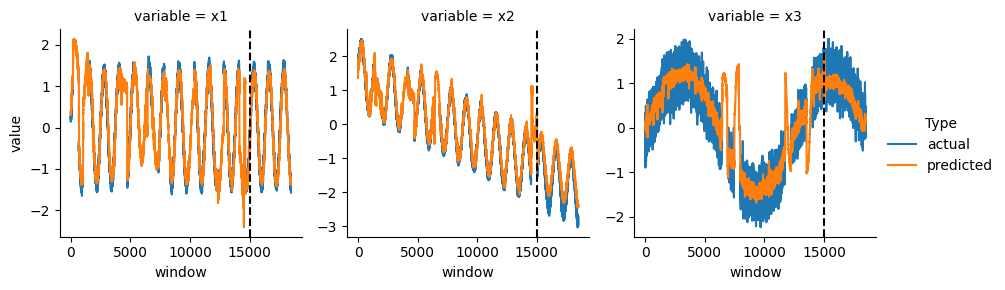

In [316]:
# plotting the predicted versus actual values over time
g = sns.FacetGrid(df_results_all_long, col="variable", col_wrap=3,
                  hue="type",  hue_order=['actual', 'predicted'],  height=3, sharey=False)
g = g.map(plt.plot, "window", "value").add_legend(title="Type")
# adding dashed vertical line at the split_time
for ax in g.axes:
    ax.axvline(split_time, ls='--', color='black')

plt.show()

In the above figure, the dashed line is added at the split time between the training and testing sets. As you can see, the model has been successful in learning the underlying patterns in the data even with the gaps. However, there are some jumps in the predicted values near the gaps. This is because there are only a few observations, with only one at the beginning of the gap, for the model to use for prediction. You could set a threshold on the number of observations required for prediction to avoid this issue, or use the predicted values as input for the next prediction.

# Conclusion

This notebook demonstrated how to effectively use the `sert` package for multivariate time series forecasting. With its intuitive API and preprocessing utilities, working with irregular time series data becomes efficient and straightforward.

### Few notes:

- In this tutorial, we didn't discuss the hyperparameter tuning process as the goal was to demonstrate how to work with the package API. We encourage you to experiment with different hyperparameters and see how they affect the model performance.

- We did not consider best practices for forecasting in this tutorial. In practical applications, you might want to introduce additional features to the data to enhance the model's performance or employ techniques such as differencing to make the data stationary.

- The package also provides another alternative model to `TimeSERT` called `TimeSERNN` which doesn't use the transformer architecture and only relies on set encoding and feedforward layers. `TimeSERNN` runs much faster but might compromise performance. You can simply replace `TimeSERT` with `TimeSERNN`, which has fewer hyperparameters, like below:

```python
from sert.models import TimeSERNN

model = TimeSERNN(num_var=1,
                 emb_dim=15,
                 num_out=y_train.shape[1],
                 task='classification')
                 
```